In [16]:
import neat
import os
import evogym.envs
from evogym import is_connected, has_actuator, get_full_connectivity, hashable
import numpy as np
import dill
import pickle as pkl
import sys
sys.path.append('../')

from hyperneat.hyperNEAT import create_phenotype_network
from hyperneat.substrate import Substrate
from hyperneat.visualize import draw_net
from dynamic_env.traverser import DynamicObstacleTraverser
from dynamic_env.env_config import EnvConfig


import itertools as it
import time
import imageio

from matplotlib import pyplot as plt


from sgr.substrates import morph_substrate, control_substrate
from sgr.generate_robot import generate_robot, eval_robot_constraint
from sgr.evogym_sim import simulate_env
from sgr.body_speciation import CustomGenome
from grid_world.graph import Graph
from grid_world.node import Node
from grid_world.tasks import *
from copy import deepcopy
from PIL import Image

In [17]:
def get_robot(genome, neat_config, env):
    if genome.robot is not None:
        robot = genome.robot
    else:
        cppn = neat.nn.FeedForwardNetwork.create(genome, neat_config)
        design_substrate = morph_substrate(5, "3d")
        design_net = create_phenotype_network(cppn, design_substrate)
        robot = generate_robot(design_net, 5)
        
    if not eval_robot_constraint(robot):
        return robot, None
    connections = get_full_connectivity(robot)
    
    env = evogym.envs.gym.make(env, body=robot, connections=connections)
    img = env.render(mode='img')
    env.close()
    return robot, img

In [18]:
with open(f"../island_cp/cp_2000.pkl", "rb") as file:
    grid: Graph = pkl.load(file)

CustomGenome.robot_func = lambda self, net, config: generate_robot(net, grid.d_nodes["0"].sgr_pop.robot_size)
CustomGenome.substrate = morph_substrate(grid.d_nodes["0"].sgr_pop.robot_size, "3d")
CustomGenome.robot_size = grid.d_nodes["0"].sgr_pop.robot_size
CustomGenome.spec_genotype_weight = 1
CustomGenome.spec_phenotype_weight = 2

0: Walker-v0
4905 0.633449098777077


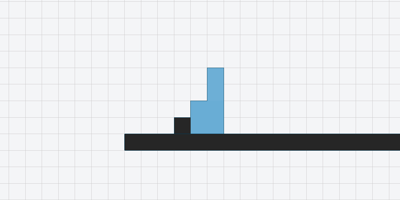

1: BridgeWalker-v0
4936 0.015458755718479322


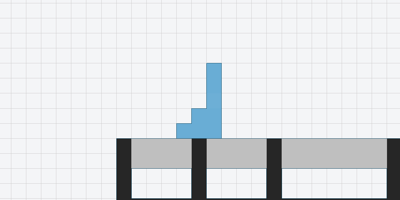

2: BidirectionalWalker-v0
5031 0.026598358798595456


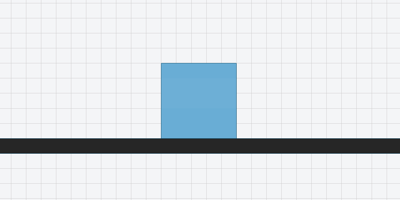

3: UpStepper-v0
4872 2.2668331014404552


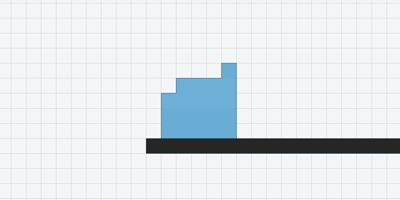

4: DownStepper-v0
4905 0.633449098777077


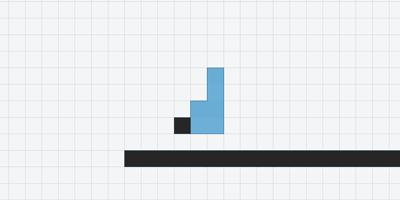

5: ObstacleTraverser-v0
4549 0.7756726280609018


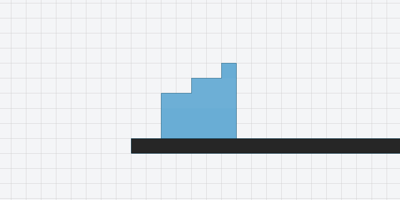

6: ObstacleTraverser-v1
5022 -1.8096635301390052e-14


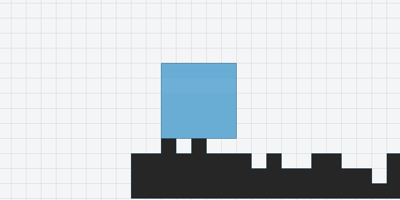

7: Hurdler-v0
542 1.041207960150806


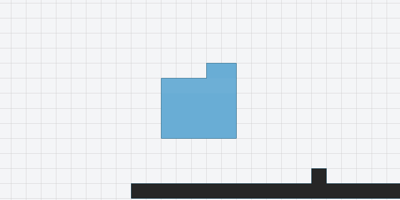

8: PlatformJumper-v0
4549 0.7756726280609018


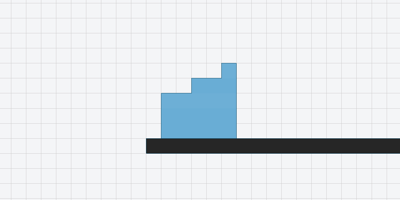

9: GapJumper-v0
4094 1.1269382809864295


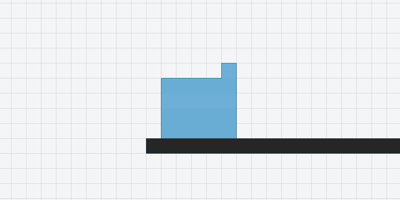

10: UpStepper-v0
5055 1.0967334379289675


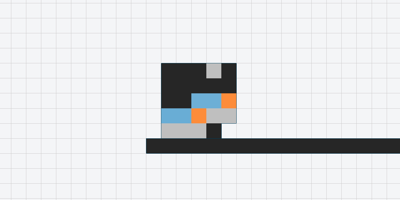

11: CaveCrawler-v0
4628 1.2468319853804541


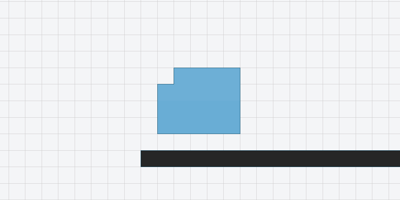

12: ObstacleTraverser-v0
4549 0.7756726280609018


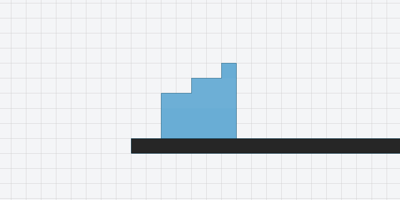

13: ObstacleTraverser-v1
3928 4.7738423723462855


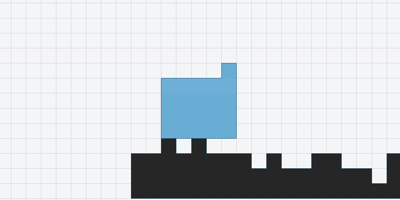

14: Walker-v0
5083 -4.363176486776865e-14


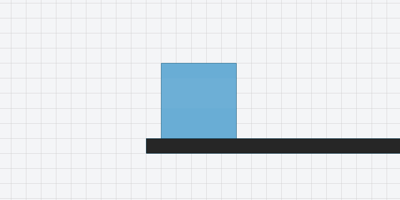

15: GapJumper-v0
4094 1.1269382809864295


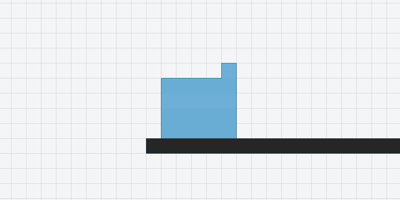

In [21]:
for key, value in grid.d_nodes.items():
    print(f"{key}: {value.task}")
    best_genome = None
    best_genome_fit = -100000
    for g in value.sgr_pop.pop.population.values():
        # print(g.key, g.fitness)
        if g.fitness != None and g.fitness > best_genome_fit:
            best_genome = g
            best_genome_fit = g.fitness
    print(best_genome.key, best_genome.fitness)
    robot, img = get_robot(best_genome, value.sgr_pop.neat_config, value.task) 
    if img is not None:
        # print(ag.robot)
        aux = Image.fromarray(img, 'RGB')
        display(aux.resize((aux.size[0]//3, aux.size[1]//3)))